# Projeto final 1 - Previsão de rendimento agrícola por redes neurais tipo MLP

<b> Grupo: </b> João O. de A. Nascimento, Emelyn Alves e Kayllanny L. da S. Oliveira
\
<b> Professor: </b> Daniel R. Cassar
\
<b> Disciplina: </b> Redes Neurais e Algoritmos Genéticos

## Importando bibliotecas

Inicialmente, é necessária a importação das bibliotecas (contidas na célula abaixo). Isso garante que todas as dependências e ferramentas essenciais estejam disponíveis para execução correta e eficiente do código. 

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
import lightning as L

/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importando e tratando conjunto de dados 

Agora, carregamos nosso conjunto de dados por meio da biblioteca `pandas`. A partir dessa tabela será possível criar um modelo capaz de prever o rendimento de acordo com seus atributos (saiba mais sobre o dataset no [README](https://github.com/Joao-otavio04/Projeto_Final_Redes_Neurais/blob/main/README.md)).  

* Importante ressaltar: os dados tabulados foram obtidos já separados em conjunto de treino (agricultural_yield_teste.csv) e teste (agricultural_yield_train.csv). 

In [2]:
features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare', 'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule']
target = ['Yield_kg_per_hectare']

df_teste = pd.read_csv("agricultural_yield_test.csv")
df_treino = pd.read_csv("agricultural_yield_train.csv")

df_teste = df_teste.reindex(features + target, axis=1) 
df_teste = df_teste.dropna()

df_treino = df_treino.reindex(features + target, axis=1)
df_treino = df_treino.dropna()

Após importar dados e remover valores ausentes,  podemos verificar os dois conjuntos de dados a seguir, teste e treino, respectivamente: 

### Conjunto de dados de treino 

In [3]:
df_teste

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,93.304721,0,132.522218,96.670922,602.386237,3,278.986563
1,83.674653,1,57.283997,99.007556,466.518251,8,836.434840
2,65.963033,1,227.895479,104.844272,510.320495,4,785.881787
3,78.692834,1,176.314126,90.136191,354.350914,5,807.884526
4,72.415684,1,160.070418,101.221668,443.993788,10,1064.542374
...,...,...,...,...,...,...,...
3995,95.094714,1,124.108262,98.970659,496.705800,5,802.209345
3996,53.256984,0,100.310322,111.448947,667.056391,8,509.646540
3997,94.145522,1,196.473704,110.003474,458.241408,3,776.013634
3998,61.452120,1,80.618357,97.815517,778.652540,4,502.319484


### Conjunto de dados de teste 

In [4]:
df_treino

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,96.415657,1,147.853040,94.593926,444.267569,3,683.759119
1,92.352626,0,281.565396,90.504644,517.585491,7,678.714861
2,63.714785,1,137.864940,97.329340,420.310945,8,934.691975
3,90.084256,1,100.946659,113.404828,547.817646,7,905.842541
4,81.600341,1,223.088908,83.048176,434.726333,6,897.584665
...,...,...,...,...,...,...,...
15995,77.053550,1,154.189768,103.115855,319.915079,7,956.781949
15996,99.795631,1,282.295839,123.598354,647.292136,4,879.682714
15997,67.478487,1,120.017122,102.308627,514.372747,8,932.829561
15998,85.176890,1,247.847389,114.956634,695.035801,6,889.738438


### Vamos analisar? 

Para ter uma noção melhor da dimensão de nossos dados, vamos verificar os valores mínimo e máximo de nosso target (rendimento): 

In [5]:
minimo = min(df_treino['Yield_kg_per_hectare'])
maximo = max(df_treino['Yield_kg_per_hectare'])

print("Mínimo rendimento:", minimo)
print("Máximo rendimento:", maximo)
print("A diferença entre eles é:", maximo - minimo)

Mínimo rendimento: 57.51489114958822
Máximo rendimento: 1385.1136002632345
A diferença entre eles é: 1327.5987091136462


Além disso, uma matriz de correlação é uma boa ferramenta para analisar a relação entre os atributos (colunas) do conjunto de dados. Vejamos: 

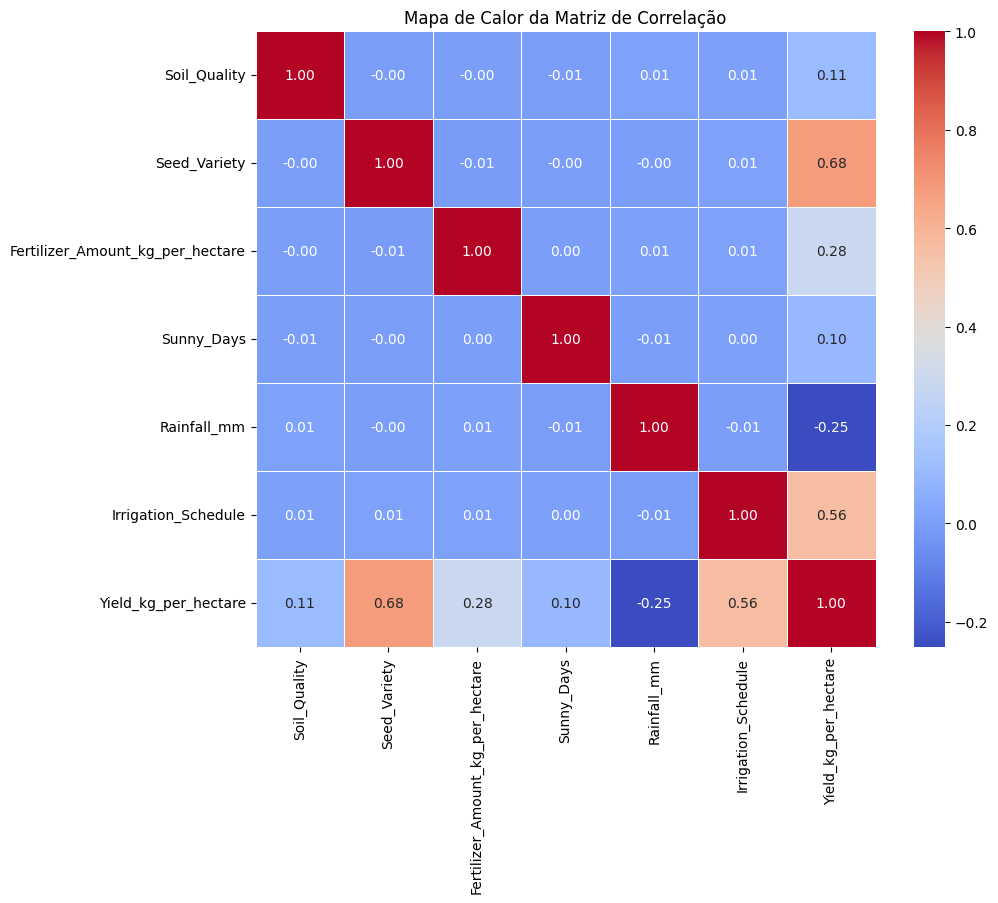

In [6]:
correlation_matrix = df_treino.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()

A partir da matriz de correlação é claro que os atributos que se correlacionam positivamente com o rendimento são: 1. Seed_variety (variedade de semente), com correlação de 0.68 e 2. Irrigation_Schedule (cronograma de irrigação), com 0.56 de correlação. E o que se relaciona negativamente é Rainfall_mm (precipitação) com correlação de -0.25. 

Ou seja, para esse conjunto de dados o tipo de semente e a frequência de irrigação influenciam mais o rendimento do que a precipitação. Isso é interessante, já que a precipitação, em geral, apresenta grandíssima influência em sistemas agrícolas reais. 

### Definindo parâmetros

Os parâmetros a seguir serão utilizados posteriormente: 

In [7]:
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

### Separação do target

Agora é possível separar o target dos atributos que serão utilizados para prevê-lo. O target será a variável: `Yield_kg_per_hectare` (rendimento em quilos por hectare). 

*Lembrando:* O target é a variável que será prevista e, nesse caso, quantificada/estimada. 

In [8]:
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

### Split treino-validação

Para verificar se a o modelo criado é bom teremos que, posteriormente, comparar o rendimento predito pelo rendimento da validação. Desse modo, devemos realizar um split do conjunto de treino em subconjuntos: 1. de treino; 2. validação. 

In [9]:
indices = df_treino.index
print(indices, len(indices))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA
)

print(indices_treino, len(indices_treino))
print()
print(indices_val, len(indices_val))

df_val = df_treino.loc[indices_val]
df_treino = df_treino.loc[indices_treino]


X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

RangeIndex(start=0, stop=16000, step=1) 16000
Index([ 2519, 11035,  3934, 14982,  4078, 12245, 12217,  9147, 11629,  3768,
       ...
        6255,  7971, 13014,  6321, 12691,  2256, 10672,  6652, 11166, 13937],
      dtype='int64', length=14400) 14400

Index([ 8987,  4178,  4313,  1666,  6784, 12065, 10246,  8625,  9889,  6176,
       ...
        4452, 12565, 12620, 13756, 14945,    97,  8368, 10148, 12993,  5542],
      dtype='int64', length=1600) 1600


### Normalização e transformação de dados

Nas células abaixo: 
1. Realizamos a normalização de dados por máximo absoluto, a fim de reduzir a dimensionalidade de cada um dos atributos. *É interessante lembrar que: as redes neurais trabalham melhor entre -1 e 1.* 

2. Transformamos os dados para treinar e testar a rede neural. A conversão dos dados de números para tensores é necessária pois o PyTorch trabalha somente com esse tipo de objeto. 

#### Normalização por máximo absoluto

In [10]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

#### Conversão para tensores

In [11]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

##### Tensores de teste

In [12]:
X_teste

tensor([[0.9331, 0.0000, 0.4418, 0.6788, 0.6905, 0.2000],
        [0.8368, 1.0000, 0.1910, 0.6952, 0.5348, 0.5333],
        [0.6596, 1.0000, 0.7597, 0.7362, 0.5850, 0.2667],
        ...,
        [0.9415, 1.0000, 0.6549, 0.7724, 0.5253, 0.2000],
        [0.6145, 1.0000, 0.2687, 0.6868, 0.8926, 0.2667],
        [0.5520, 0.0000, 0.4083, 0.6341, 0.6683, 0.2667]])

In [13]:
y_teste

tensor([[0.2014],
        [0.6039],
        [0.5674],
        ...,
        [0.5603],
        [0.3627],
        [0.1856]])

##### Tensores de treino

In [14]:
X_treino

tensor([[0.9795, 0.0000, 0.7640, 0.7867, 0.4237, 0.2000],
        [0.9797, 0.0000, 0.9775, 0.5857, 0.6576, 0.2667],
        [0.9986, 1.0000, 0.4590, 0.6481, 0.5381, 0.1333],
        ...,
        [0.6414, 1.0000, 0.9437, 0.7126, 0.5219, 0.3333],
        [0.6388, 1.0000, 0.4695, 0.6392, 0.3804, 0.2667],
        [0.9902, 1.0000, 0.5284, 0.7755, 0.6688, 0.3333]])

In [15]:
y_treino

tensor([[0.3213],
        [0.3385],
        [0.4438],
        ...,
        [0.6514],
        [0.4705],
        [0.5933]])

##### Tensores de validação 

In [16]:
X_val

tensor([[0.6182, 1.0000, 0.3226, 0.7208, 0.6738, 0.5333],
        [0.9165, 0.0000, 0.1888, 0.6953, 0.4263, 0.0667],
        [0.6729, 1.0000, 0.5926, 0.7751, 0.6263, 0.2667],
        ...,
        [0.7481, 1.0000, 0.2723, 0.6990, 0.4905, 0.4667],
        [0.5995, 1.0000, 0.7954, 0.6793, 0.6092, 0.5333],
        [0.5068, 1.0000, 0.8737, 0.7273, 0.5378, 0.5333]])

In [17]:
y_val

tensor([[0.6336],
        [0.1526],
        [0.5981],
        ...,
        [0.5879],
        [0.7066],
        [0.6803]])

## Treinando a rede com uma arquitetura aleatória

Esta célula é o passo inicial para criarmos e treinarmos nosso modelo. Utiliza a classe mãe, o `DataModule` do `Lightning`, que encapsula diversas informações necessárias para preparar nossos dados e futuramente usar o `Lightning` no treinamento.

Obs: o número de trabalhadores foi selecionado como 8, pois o código foi trabalhado em um computador de alto desempenho (HPC).

Devemos criar uma classe para a MLP, a qual herda de `L.LightningModule` e registrar como proceder durante as etapas de treino, validação e teste.

In [18]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 8,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

Para verificar se os dados estavam devidamente tratados e se funcionariam em nossa MLP (Multilayer Perceptron), criamos uma MLP de teste com arquitetura aleatória. Veja:  

In [19]:
class MLP_teste(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )  
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

Com a MLP teste criada, definimos o número de épocas e criamos o treinador, que executará o treinamento pela quantidade de épocas especificada.

In [20]:
NUM_EPOCAS = 20

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Precisamos também criar uma instância da classe `DataModule` que definimos acima.



In [21]:
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

Antes de treinar, precisamos também criar uma instância da rede neural.



In [22]:
num_dados_de_entrada = 6
num_dados_de_saida = 1
neuronios_c1 = random.randint(1, 120)
neuronios_c2 = random.randint(1, 120)

mlp_teste = MLP_teste(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

Finalmente, temos tudo que precisamos. Podemos rodar o método `fit` do nosso treinador na nossa instância da rede neural, fornecendo também uma instância do `DataModule` como argumento.



In [23]:
treinador.fit(mlp_teste, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.3 K 
---------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 57/57 [00:00<00:00, 182.22it/s, v_num=486, loss=0.0171]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 57/57 [00:00<00:00, 289.58it/s, v_num=486, loss=0.0163, val_loss=0.0216]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 57/57 [00:00<00:00, 292.67it/s, v_num=486, loss=0.0163, val_loss=0.0215]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 57/57 [00:00<00:00, 321.83it/s, v_num=486, loss=0.0163, val_loss=0.0215]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 57/57 [00:00<00:00, 314.13it/s, v_num=486, loss=0.0163, val_loss=0.0215]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 57/57 [00:00<00:00, 322.05it/s, v_num=486, loss=0.0163, val_loss=0.0215]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 57/57 [00:00<00:00, 320.29it/s, v_num=486, loss=0.0163, val_loss=0.0215]
Validation: |          | 0/? [00:00<?, ?it/s]
Ep

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 57/57 [00:00<00:00, 255.64it/s, v_num=486, loss=0.0162, val_loss=0.0214]


### Curva de aprenzidado (MLP teste)

O gráfico abaixo mostra a curva de aprendizado, comparando o treino com a validação. A partir dele verificamos que a curva de treino e validação convergem com o passar das épocas. Logo, o aprendizado é bom. 

Text(0, 0.5, 'Loss')

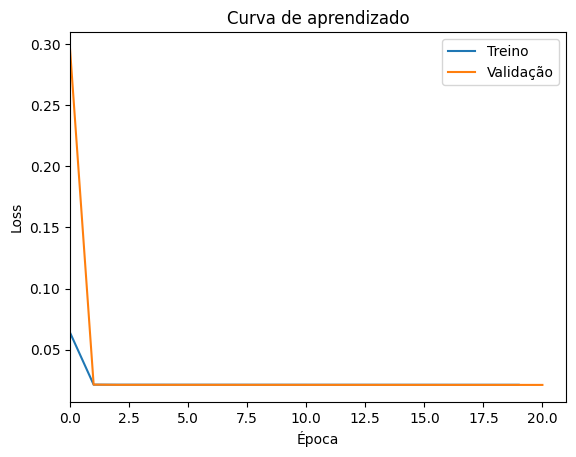

In [24]:
figura, eixo = plt.subplots()

ca_treino = mlp_teste.curva_aprendizado_treino
ca_val = mlp_teste.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

## Testando a rede com a arquitetura aleatória

Antes de testar a rede neural é preciso deixá-la no modo de avaliação do PyTorch. 

In [25]:
mlp_teste.eval()

MLP_teste(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=9, out_features=111, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=111, out_features=1, bias=True)
  )
)

### Calculando RMSE (MLP teste)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [26]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = mlp_teste(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print("O RMSE da MLP teste foi:", {RMSE})

O RMSE da MLP teste foi: {199.67125845383455}


/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


O RMSE desse modelo de teste é razoável, se levarmos em consideração que o rendimento máximo dos dados fornecidos pelo conjunto de dados do treino é maior que 1300 kg/hec. 

Após todos esses passos, podemos observar que os dados estão adequados e podemos partir para o nosso modelo real. 

## Treinando diferentes MLPs

*Hiperparâmetros:* neurônios (cada camada), camadas e dropout.

A seguir criamos o modelo de rede que será treinado com diferentes arquiteturas, variando os hiperparâmetros listados acima.

In [43]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, num_targets, neuronios, dropouts
    ):
        super().__init__()    
        
        camadas = []   
        
        neuronios = [num_dados_entrada]+neuronios
    
        for k in range(len(neuronios)-1): # Camada de entrada + camadas ocultas 
            camadas.append(nn.Linear(neuronios[k], neuronios[k+1]))
            camadas.append(nn.ReLU())
            camadas.append(nn.Dropout(dropouts[k]))
        
        camadas.append(nn.Linear(neuronios[-1], num_targets)) # Camada de saída
        
        self.camadas = nn.Sequential(*camadas) 
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

### Função `objective`

A função `objective` é responsável por explorar as diferentes possíveis arquiteturas, variando os hiperparâmetros selecionados e utilizando o Optuna para encontrar o melhor modelo dentre as arquiteturas testadas, sendo estes treinados por 100 épocas, ou até a parada do early stopping.

In [42]:
def objective(trial: optuna.trial.Trial) -> float:

    """ Explora as diferentes arquiteturas, sugerindo número de camadas, neurônios e dropouts.
        Em seguida, cria o modelo de rede, treina a rede e retorna a métrica 'val_loss'. """
    
    MAX_EPOCHS = 100

    # Otimizamos o número de camadas, neurônios em cada camada oculta e dropouts.
    num_dados_entrada = 6
    num_targets = 1
    
    neuronios = []   
    dropouts = []
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120)
        neuronios.append(neuronio)
        dropout = trial.suggest_float("dropout", 0.2, 0.5)
        dropouts.append(dropout)
        
    print(neuronios, dropouts)

    model = MLP(num_dados_entrada, num_targets, neuronios, dropouts)
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
    
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback], enable_progress_bar=False) 
    
    treinador.fit(model, datamodule=datamodule)

    return treinador.callback_metrics["val_loss"].item()

### Tentativas de otimização

Nesta célula, utilizamos a função e a classe definidas anteriormente para treinar diferentes arquiteturas. Levando em consideração que: a cada "trial" há uma tentativa de otimização e, teoricamete, uma arquitetura é treinada a cada tentativa. Então treinamos 150 diferentes arquiteturas. 

In [29]:
N_TRIALS = 150
num_dados_entrada = 6
num_targets = 1

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=N_TRIALS)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2024-05-21 07:56:30,846] A new study created in memory with name: no-name-43b94f3f-950a-483c-b8c0-fcff22a47898
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 8.4 K 
---------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[34, 53, 64, 43] [0.23339563357129495, 0.23339563357129495, 0.23339563357129495, 0.23339563357129495]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:56:49,134] Trial 0 finished with value: 0.01787455938756466 and parameters: {'n_layers': 4, 'n_units0': 34, 'dropout': 0.23339563357129495, 'n_units1': 53, 'n_units2': 64, 'n_units3': 43}. Best is trial 0 with value: 0.01787455938756466.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 14.7 K
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params
0.059     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[100, 50, 112, 28] [0.3309808115306765, 0.3309808115306765, 0.3309808115306765, 0.3309808115306765]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:57:07,332] Trial 1 finished with value: 0.018755203112959862 and parameters: {'n_layers': 4, 'n_units0': 100, 'dropout': 0.3309808115306765, 'n_units1': 50, 'n_units2': 112, 'n_units3': 28}. Best is trial 0 with value: 0.01787455938756466.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.6 K 
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[110, 11, 27, 49, 17] [0.4889404381801719, 0.4889404381801719, 0.4889404381801719, 0.4889404381801719, 0.4889404381801719]


[I 2024-05-21 07:57:17,231] Trial 2 finished with value: 0.021402480080723763 and parameters: {'n_layers': 5, 'n_units0': 110, 'dropout': 0.4889404381801719, 'n_units1': 11, 'n_units2': 27, 'n_units3': 49, 'n_units4': 17}. Best is trial 0 with value: 0.01787455938756466.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.5 K 
---------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[32, 62, 5, 108, 30] [0.2325896324008446, 0.2325896324008446, 0.2325896324008446, 0.2325896324008446, 0.2325896324008446]


[I 2024-05-21 07:57:24,210] Trial 3 finished with value: 0.021370356902480125 and parameters: {'n_layers': 5, 'n_units0': 32, 'dropout': 0.2325896324008446, 'n_units1': 62, 'n_units2': 5, 'n_units3': 108, 'n_units4': 30}. Best is trial 0 with value: 0.01787455938756466.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 14.3 K
---------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[106, 94, 36] [0.4012981094657919, 0.4012981094657919, 0.4012981094657919]


[I 2024-05-21 07:57:32,731] Trial 4 finished with value: 0.015988856554031372 and parameters: {'n_layers': 3, 'n_units0': 106, 'dropout': 0.4012981094657919, 'n_units1': 94, 'n_units2': 36}. Best is trial 4 with value: 0.015988856554031372.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 193   
---------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[24] [0.24982275973905424]


[I 2024-05-21 07:57:39,501] Trial 5 finished with value: 0.011712245643138885 and parameters: {'n_layers': 1, 'n_units0': 24, 'dropout': 0.24982275973905424}. Best is trial 5 with value: 0.011712245643138885.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 27.3 K
---------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120, 99, 64, 51, 89] [0.3008755408220767, 0.3008755408220767, 0.3008755408220767, 0.3008755408220767, 0.3008755408220767]


[I 2024-05-21 07:57:46,466] Trial 6 finished with value: 0.021224617958068848 and parameters: {'n_layers': 5, 'n_units0': 120, 'dropout': 0.3008755408220767, 'n_units1': 99, 'n_units2': 64, 'n_units3': 51, 'n_units4': 89}. Best is trial 5 with value: 0.011712245643138885.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 209   
---------------------------------------
209       Trainable params
0         Non-trainable params
209       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[26] [0.22867190103360902]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:58:02,336] Trial 7 finished with value: 0.011175207793712616 and parameters: {'n_layers': 1, 'n_units0': 26, 'dropout': 0.22867190103360902}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 14.5 K
---------------------------------------
14.5 K    Trainable params
0         Non-trainable params
14.5 K    Total params
0.058     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[65, 88, 92] [0.42804943107324356, 0.42804943107324356, 0.42804943107324356]


[I 2024-05-21 07:58:06,853] Trial 8 finished with value: 0.018003273755311966 and parameters: {'n_layers': 3, 'n_units0': 65, 'dropout': 0.42804943107324356, 'n_units1': 88, 'n_units2': 92}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 15.4 K
---------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.061     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[108, 68, 38, 114] [0.23807522662524144, 0.23807522662524144, 0.23807522662524144, 0.23807522662524144]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:58:25,462] Trial 9 finished with value: 0.01765637844800949 and parameters: {'n_layers': 4, 'n_units0': 108, 'dropout': 0.23807522662524144, 'n_units1': 68, 'n_units2': 38, 'n_units3': 114}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 73    
---------------------------------------
73        Trainable params
0         Non-trainable params
73        Total params
0.000     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[9] [0.2965456221629674]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:58:41,402] Trial 10 finished with value: 0.011710996739566326 and parameters: {'n_layers': 1, 'n_units0': 9, 'dropout': 0.2965456221629674}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 49    
---------------------------------------
49        Trainable params
0         Non-trainable params
49        Total params
0.000     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[6] [0.29637798169934404]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:58:57,536] Trial 11 finished with value: 0.016578318551182747 and parameters: {'n_layers': 1, 'n_units0': 6, 'dropout': 0.29637798169934404}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 113   
---------------------------------------
113       Trainable params
0         Non-trainable params
113       Total params
0.000     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[7, 7] [0.2843823518484094, 0.2843823518484094]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:59:14,905] Trial 12 finished with value: 0.019429057836532593 and parameters: {'n_layers': 2, 'n_units0': 7, 'dropout': 0.2843823518484094, 'n_units1': 7}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[50, 31] [0.20320337763634364, 0.20320337763634364]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:59:32,383] Trial 13 finished with value: 0.012593289837241173 and parameters: {'n_layers': 2, 'n_units0': 50, 'dropout': 0.20320337763634364, 'n_units1': 31}. Best is trial 7 with value: 0.011175207793712616.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 569   
---------------------------------------
569       Trainable params
0         Non-trainable params
569       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[71] [0.3659044726309845]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 07:59:48,125] Trial 14 finished with value: 0.008490750566124916 and parameters: {'n_layers': 1, 'n_units0': 71, 'dropout': 0.3659044726309845}. Best is trial 14 with value: 0.008490750566124916.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 9.8 K 
---------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
0.039     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[82, 110] [0.38390330947095386, 0.38390330947095386]


[I 2024-05-21 07:59:57,907] Trial 15 finished with value: 0.011499417945742607 and parameters: {'n_layers': 2, 'n_units0': 82, 'dropout': 0.38390330947095386, 'n_units1': 110}. Best is trial 14 with value: 0.008490750566124916.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 505   
---------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[63] [0.34663327705089614]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:00:13,871] Trial 16 finished with value: 0.005485069938004017 and parameters: {'n_layers': 1, 'n_units0': 63, 'dropout': 0.34663327705089614}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 9.4 K 
---------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.037     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[73, 118] [0.35388298262239354, 0.35388298262239354]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:00:30,290] Trial 17 finished with value: 0.011434262618422508 and parameters: {'n_layers': 2, 'n_units0': 73, 'dropout': 0.35388298262239354, 'n_units1': 118}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.0 K 
---------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[52, 32, 117] [0.44718279412098405, 0.44718279412098405, 0.44718279412098405]


[I 2024-05-21 08:00:35,653] Trial 18 finished with value: 0.01994965597987175 and parameters: {'n_layers': 3, 'n_units0': 52, 'dropout': 0.44718279412098405, 'n_units1': 32, 'n_units2': 117}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 633   
---------------------------------------
633       Trainable params
0         Non-trainable params
633       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[79] [0.3533172210648463]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:00:51,317] Trial 19 finished with value: 0.0063866861164569855 and parameters: {'n_layers': 1, 'n_units0': 79, 'dropout': 0.3533172210648463}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 7.7 K 
---------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[88, 79] [0.33152931593966545, 0.33152931593966545]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:01:07,433] Trial 20 finished with value: 0.009572252631187439 and parameters: {'n_layers': 2, 'n_units0': 88, 'dropout': 0.33152931593966545, 'n_units1': 79}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 457   
---------------------------------------
457       Trainable params
0         Non-trainable params
457       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[57] [0.37060297783765495]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:01:23,522] Trial 21 finished with value: 0.007817590609192848 and parameters: {'n_layers': 1, 'n_units0': 57, 'dropout': 0.37060297783765495}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 425   
---------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[53] [0.411249293219799]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:01:39,685] Trial 22 finished with value: 0.007643245626240969 and parameters: {'n_layers': 1, 'n_units0': 53, 'dropout': 0.411249293219799}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 337   
---------------------------------------
337       Trainable params
0         Non-trainable params
337       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[42] [0.4211540083053013]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:01:55,270] Trial 23 finished with value: 0.009200628846883774 and parameters: {'n_layers': 1, 'n_units0': 42, 'dropout': 0.4211540083053013}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.2 K 
---------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[86, 30] [0.46025040231603775, 0.46025040231603775]


[I 2024-05-21 08:01:59,610] Trial 24 finished with value: 0.012951361946761608 and parameters: {'n_layers': 2, 'n_units0': 86, 'dropout': 0.46025040231603775, 'n_units1': 30}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 529   
---------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[66] [0.39462746642105034]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:02:14,901] Trial 25 finished with value: 0.009526717476546764 and parameters: {'n_layers': 1, 'n_units0': 66, 'dropout': 0.39462746642105034}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[81, 18] [0.3193198914852732, 0.3193198914852732]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:02:32,551] Trial 26 finished with value: 0.011914771981537342 and parameters: {'n_layers': 2, 'n_units0': 81, 'dropout': 0.3193198914852732, 'n_units1': 18}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 345   
---------------------------------------
345       Trainable params
0         Non-trainable params
345       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[43] [0.3483442458633909]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:02:48,567] Trial 27 finished with value: 0.009842073544859886 and parameters: {'n_layers': 1, 'n_units0': 43, 'dropout': 0.3483442458633909}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 9.5 K 
---------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[92, 50, 81] [0.40732352756618656, 0.40732352756618656, 0.40732352756618656]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:03:05,988] Trial 28 finished with value: 0.01698215678334236 and parameters: {'n_layers': 3, 'n_units0': 92, 'dropout': 0.40732352756618656, 'n_units1': 50, 'n_units2': 81}. Best is trial 16 with value: 0.005485069938004017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 585   
---------------------------------------
585       Trainable params
0         Non-trainable params
585       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[73] [0.2661312867985638]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:03:22,402] Trial 29 finished with value: 0.004225536715239286 and parameters: {'n_layers': 1, 'n_units0': 73, 'dropout': 0.2661312867985638}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.5 K 
---------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[76, 76] [0.2681558403732305, 0.2681558403732305]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:03:41,238] Trial 30 finished with value: 0.013823816552758217 and parameters: {'n_layers': 2, 'n_units0': 76, 'dropout': 0.2681558403732305, 'n_units1': 76}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 481   
---------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[60] [0.31750910850179626]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:03:57,281] Trial 31 finished with value: 0.0052921767346560955 and parameters: {'n_layers': 1, 'n_units0': 60, 'dropout': 0.31750910850179626}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 489   
---------------------------------------
489       Trainable params
0         Non-trainable params
489       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[61] [0.3239567396786802]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:04:13,646] Trial 32 finished with value: 0.008411345072090626 and parameters: {'n_layers': 1, 'n_units0': 61, 'dropout': 0.3239567396786802}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 761   
---------------------------------------
761       Trainable params
0         Non-trainable params
761       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[95] [0.26650797907456336]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:04:30,181] Trial 33 finished with value: 0.005993962287902832 and parameters: {'n_layers': 1, 'n_units0': 95, 'dropout': 0.26650797907456336}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 753   
---------------------------------------
753       Trainable params
0         Non-trainable params
753       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[94] [0.26700800064013]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:04:45,907] Trial 34 finished with value: 0.005018271971493959 and parameters: {'n_layers': 1, 'n_units0': 94, 'dropout': 0.26700800064013}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 11.7 K
---------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[99, 109] [0.262309718357495, 0.262309718357495]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:05:03,026] Trial 35 finished with value: 0.009292660281062126 and parameters: {'n_layers': 2, 'n_units0': 99, 'dropout': 0.262309718357495, 'n_units1': 109}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 561   
---------------------------------------
561       Trainable params
0         Non-trainable params
561       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[70] [0.31227233735235893]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:05:19,089] Trial 36 finished with value: 0.007648652419447899 and parameters: {'n_layers': 1, 'n_units0': 70, 'dropout': 0.31227233735235893}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.1 K 
---------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[44, 42, 13, 92] [0.2777810598083093, 0.2777810598083093, 0.2777810598083093, 0.2777810598083093]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:05:40,101] Trial 37 finished with value: 0.020209548994898796 and parameters: {'n_layers': 4, 'n_units0': 44, 'dropout': 0.2777810598083093, 'n_units1': 42, 'n_units2': 13, 'n_units3': 92}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 473   
---------------------------------------
473       Trainable params
0         Non-trainable params
473       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[59] [0.24559791398369163]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:05:56,045] Trial 38 finished with value: 0.00518670491874218 and parameters: {'n_layers': 1, 'n_units0': 59, 'dropout': 0.24559791398369163}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 18.4 K
---------------------------------------
18.4 K    Trainable params
0         Non-trainable params
18.4 K    Total params
0.074     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[115, 84, 91] [0.21552194911220468, 0.21552194911220468, 0.21552194911220468]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:06:14,841] Trial 39 finished with value: 0.014275253750383854 and parameters: {'n_layers': 3, 'n_units0': 115, 'dropout': 0.21552194911220468, 'n_units1': 84, 'n_units2': 91}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[35, 22] [0.24720139064482566, 0.24720139064482566]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:06:32,572] Trial 40 finished with value: 0.01351301558315754 and parameters: {'n_layers': 2, 'n_units0': 35, 'dropout': 0.24720139064482566, 'n_units1': 22}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 481   
---------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[60] [0.2557488820390495]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:06:48,419] Trial 41 finished with value: 0.00742226280272007 and parameters: {'n_layers': 1, 'n_units0': 60, 'dropout': 0.2557488820390495}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 521   
---------------------------------------
521       Trainable params
0         Non-trainable params
521       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[65] [0.23038579353671496]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:07:05,179] Trial 42 finished with value: 0.006173283327370882 and parameters: {'n_layers': 1, 'n_units0': 65, 'dropout': 0.23038579353671496}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 825   
---------------------------------------
825       Trainable params
0         Non-trainable params
825       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[103] [0.3391584156541147]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:07:22,011] Trial 43 finished with value: 0.007288880180567503 and parameters: {'n_layers': 1, 'n_units0': 103, 'dropout': 0.3391584156541147}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 449   
---------------------------------------
449       Trainable params
0         Non-trainable params
449       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[56] [0.2842080312074138]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:07:38,002] Trial 44 finished with value: 0.007697631139308214 and parameters: {'n_layers': 1, 'n_units0': 56, 'dropout': 0.2842080312074138}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 12.0 K
---------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[68, 69, 56, 15, 118] [0.29928872061420936, 0.29928872061420936, 0.29928872061420936, 0.29928872061420936, 0.29928872061420936]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:07:58,284] Trial 45 finished with value: 0.021372666582465172 and parameters: {'n_layers': 5, 'n_units0': 68, 'dropout': 0.29928872061420936, 'n_units1': 69, 'n_units2': 56, 'n_units3': 15, 'n_units4': 118}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 601   
---------------------------------------
601       Trainable params
0         Non-trainable params
601       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[75] [0.2148559837722439]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:08:14,488] Trial 46 finished with value: 0.0059786224737763405 and parameters: {'n_layers': 1, 'n_units0': 75, 'dropout': 0.2148559837722439}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 385   
---------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[48] [0.3111373296488876]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:08:30,722] Trial 47 finished with value: 0.008926397189497948 and parameters: {'n_layers': 1, 'n_units0': 48, 'dropout': 0.3111373296488876}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.0 K 
---------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[61, 41] [0.24584118519166656, 0.24584118519166656]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:08:49,943] Trial 48 finished with value: 0.012763024307787418 and parameters: {'n_layers': 2, 'n_units0': 61, 'dropout': 0.24584118519166656, 'n_units1': 41}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 121   
---------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[15] [0.2931369563009124]


[I 2024-05-21 08:08:55,660] Trial 49 finished with value: 0.005691898986697197 and parameters: {'n_layers': 1, 'n_units0': 15, 'dropout': 0.2931369563009124}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 681   
---------------------------------------
681       Trainable params
0         Non-trainable params
681       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[85] [0.27796756420049473]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:09:12,069] Trial 50 finished with value: 0.004537991713732481 and parameters: {'n_layers': 1, 'n_units0': 85, 'dropout': 0.27796756420049473}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 705   
---------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[88] [0.2762858745854496]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:09:28,328] Trial 51 finished with value: 0.005337315145879984 and parameters: {'n_layers': 1, 'n_units0': 88, 'dropout': 0.2762858745854496}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 713   
---------------------------------------
713       Trainable params
0         Non-trainable params
713       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[89] [0.2756105735035097]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:09:44,285] Trial 52 finished with value: 0.006282808259129524 and parameters: {'n_layers': 1, 'n_units0': 89, 'dropout': 0.2756105735035097}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 777   
---------------------------------------
777       Trainable params
0         Non-trainable params
777       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[97] [0.23975107851047733]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:10:01,042] Trial 53 finished with value: 0.004492805805057287 and parameters: {'n_layers': 1, 'n_units0': 97, 'dropout': 0.23975107851047733}. Best is trial 29 with value: 0.004225536715239286.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 809   
---------------------------------------
809       Trainable params
0         Non-trainable params
809       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[101] [0.23906196024239193]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:10:17,804] Trial 54 finished with value: 0.004077245481312275 and parameters: {'n_layers': 1, 'n_units0': 101, 'dropout': 0.23906196024239193}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 12.1 K
---------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[110, 101] [0.2183170827616798, 0.2183170827616798]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:10:35,731] Trial 55 finished with value: 0.008718015626072884 and parameters: {'n_layers': 2, 'n_units0': 110, 'dropout': 0.2183170827616798, 'n_units1': 101}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 785   
---------------------------------------
785       Trainable params
0         Non-trainable params
785       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[98] [0.23836578703457229]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:10:52,249] Trial 56 finished with value: 0.005893982481211424 and parameters: {'n_layers': 1, 'n_units0': 98, 'dropout': 0.23836578703457229}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 7.2 K 
---------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[105, 60] [0.20101016415938144, 0.20101016415938144]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:11:08,458] Trial 57 finished with value: 0.007268030196428299 and parameters: {'n_layers': 2, 'n_units0': 105, 'dropout': 0.20101016415938144, 'n_units1': 60}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 665   
---------------------------------------
665       Trainable params
0         Non-trainable params
665       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[83] [0.25406020540860974]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:11:24,644] Trial 58 finished with value: 0.004958427976816893 and parameters: {'n_layers': 1, 'n_units0': 83, 'dropout': 0.25406020540860974}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 20.4 K
---------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[84, 119, 49, 74] [0.2257554065328972, 0.2257554065328972, 0.2257554065328972, 0.2257554065328972]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:11:44,168] Trial 59 finished with value: 0.01936795748770237 and parameters: {'n_layers': 4, 'n_units0': 84, 'dropout': 0.2257554065328972, 'n_units1': 119, 'n_units2': 49, 'n_units3': 74}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 753   
---------------------------------------
753       Trainable params
0         Non-trainable params
753       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[94] [0.2546211560402143]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:12:00,037] Trial 60 finished with value: 0.0051060086116194725 and parameters: {'n_layers': 1, 'n_units0': 94, 'dropout': 0.2546211560402143}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 809   
---------------------------------------
809       Trainable params
0         Non-trainable params
809       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[101] [0.25877649931198893]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:12:16,274] Trial 61 finished with value: 0.005718663800507784 and parameters: {'n_layers': 1, 'n_units0': 101, 'dropout': 0.25877649931198893}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 737   
---------------------------------------
737       Trainable params
0         Non-trainable params
737       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[92] [0.23564162464540334]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:12:32,482] Trial 62 finished with value: 0.004845980554819107 and parameters: {'n_layers': 1, 'n_units0': 92, 'dropout': 0.23564162464540334}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 625   
---------------------------------------
625       Trainable params
0         Non-trainable params
625       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[78] [0.2402048348207838]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:12:48,585] Trial 63 finished with value: 0.00508791022002697 and parameters: {'n_layers': 1, 'n_units0': 78, 'dropout': 0.2402048348207838}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 881   
---------------------------------------
881       Trainable params
0         Non-trainable params
881       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[110] [0.2284927544345444]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:13:05,010] Trial 64 finished with value: 0.005055934190750122 and parameters: {'n_layers': 1, 'n_units0': 110, 'dropout': 0.2284927544345444}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 729   
---------------------------------------
729       Trainable params
0         Non-trainable params
729       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[91] [0.2685236959443073]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:13:21,081] Trial 65 finished with value: 0.007097515277564526 and parameters: {'n_layers': 1, 'n_units0': 91, 'dropout': 0.2685236959443073}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.9 K 
---------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[83, 16] [0.2124971285268737, 0.2124971285268737]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:13:39,034] Trial 66 finished with value: 0.010094494558870792 and parameters: {'n_layers': 2, 'n_units0': 83, 'dropout': 0.2124971285268737, 'n_units1': 16}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 769   
---------------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[96] [0.289077032083817]


[I 2024-05-21 08:13:41,533] Trial 67 finished with value: 0.0067795212380588055 and parameters: {'n_layers': 1, 'n_units0': 96, 'dropout': 0.289077032083817}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 681   
---------------------------------------
681       Trainable params
0         Non-trainable params
681       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[85] [0.22354885998988808]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:13:58,081] Trial 68 finished with value: 0.0056708138436079025 and parameters: {'n_layers': 1, 'n_units0': 85, 'dropout': 0.22354885998988808}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[114] [0.23719619505978362]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:14:14,332] Trial 69 finished with value: 0.004241899121552706 and parameters: {'n_layers': 1, 'n_units0': 114, 'dropout': 0.23719619505978362}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 921   
---------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[115] [0.23474838449951785]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:14:30,649] Trial 70 finished with value: 0.005630291532725096 and parameters: {'n_layers': 1, 'n_units0': 115, 'dropout': 0.23474838449951785}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.25537722756632736]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:14:47,362] Trial 71 finished with value: 0.004381642211228609 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.25537722756632736}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.2072009074463136]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:15:04,254] Trial 72 finished with value: 0.0041441116482019424 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.2072009074463136}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 953   
---------------------------------------
953       Trainable params
0         Non-trainable params
953       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[119] [0.20446471196186103]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:15:20,669] Trial 73 finished with value: 0.004789377097040415 and parameters: {'n_layers': 1, 'n_units0': 119, 'dropout': 0.20446471196186103}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.20472347577518457]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:15:37,265] Trial 74 finished with value: 0.004477850627154112 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.20472347577518457}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 929   
---------------------------------------
929       Trainable params
0         Non-trainable params
929       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[116] [0.22194601150252088]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:15:53,735] Trial 75 finished with value: 0.006125858519226313 and parameters: {'n_layers': 1, 'n_units0': 116, 'dropout': 0.22194601150252088}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.2 K 
---------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[119, 44] [0.20492248301252555, 0.20492248301252555]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:16:12,491] Trial 76 finished with value: 0.009142554365098476 and parameters: {'n_layers': 2, 'n_units0': 119, 'dropout': 0.20492248301252555, 'n_units1': 44}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 865   
---------------------------------------
865       Trainable params
0         Non-trainable params
865       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[108] [0.21093491481784743]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:16:28,639] Trial 77 finished with value: 0.005464569199830294 and parameters: {'n_layers': 1, 'n_units0': 108, 'dropout': 0.21093491481784743}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.2453226398417736]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:16:45,250] Trial 78 finished with value: 0.004607326351106167 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.2453226398417736}. Best is trial 54 with value: 0.004077245481312275.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 905   
---------------------------------------
905       Trainable params
0         Non-trainable params
905       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[113] [0.22312699468005634]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:17:01,811] Trial 79 finished with value: 0.003380507230758667 and parameters: {'n_layers': 1, 'n_units0': 113, 'dropout': 0.22312699468005634}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 12.9 K
---------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[113, 58, 78, 6, 57] [0.2092039366634537, 0.2092039366634537, 0.2092039366634537, 0.2092039366634537, 0.2092039366634537]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:17:22,264] Trial 80 finished with value: 0.02138218656182289 and parameters: {'n_layers': 5, 'n_units0': 113, 'dropout': 0.2092039366634537, 'n_units1': 58, 'n_units2': 78, 'n_units3': 6, 'n_units4': 57}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 833   
---------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[104] [0.22984945227751072]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:17:38,822] Trial 81 finished with value: 0.004745045211166143 and parameters: {'n_layers': 1, 'n_units0': 104, 'dropout': 0.22984945227751072}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 857   
---------------------------------------
857       Trainable params
0         Non-trainable params
857       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[107] [0.23984490331823546]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:17:56,026] Trial 82 finished with value: 0.0046233804896473885 and parameters: {'n_layers': 1, 'n_units0': 107, 'dropout': 0.23984490331823546}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.48862009447077925]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:18:12,912] Trial 83 finished with value: 0.007314162328839302 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.48862009447077925}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.22080934305414088]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:18:30,076] Trial 84 finished with value: 0.006145260762423277 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.22080934305414088}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 905   
---------------------------------------
905       Trainable params
0         Non-trainable params
905       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[113] [0.20013316504168902]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:18:47,098] Trial 85 finished with value: 0.005376720800995827 and parameters: {'n_layers': 1, 'n_units0': 113, 'dropout': 0.20013316504168902}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 889   
---------------------------------------
889       Trainable params
0         Non-trainable params
889       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[111] [0.25171788110008225]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:19:03,449] Trial 86 finished with value: 0.004663113504648209 and parameters: {'n_layers': 1, 'n_units0': 111, 'dropout': 0.25171788110008225}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.2 K 
---------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[106, 4] [0.23168085679542832, 0.23168085679542832]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:19:21,451] Trial 87 finished with value: 0.013937565498054028 and parameters: {'n_layers': 2, 'n_units0': 106, 'dropout': 0.23168085679542832, 'n_units1': 4}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 809   
---------------------------------------
809       Trainable params
0         Non-trainable params
809       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[101] [0.262038456887592]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:19:38,873] Trial 88 finished with value: 0.005263869650661945 and parameters: {'n_layers': 1, 'n_units0': 101, 'dropout': 0.262038456887592}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 929   
---------------------------------------
929       Trainable params
0         Non-trainable params
929       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[116] [0.24551292097835387]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:19:55,636] Trial 89 finished with value: 0.0038335134740918875 and parameters: {'n_layers': 1, 'n_units0': 116, 'dropout': 0.24551292097835387}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.21682754555542796]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:20:12,038] Trial 90 finished with value: 0.006207684986293316 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.21682754555542796}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.24485817078732325]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:20:28,289] Trial 91 finished with value: 0.00511532835662365 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.24485817078732325}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[114] [0.25066163267266595]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:20:44,765] Trial 92 finished with value: 0.005830768961459398 and parameters: {'n_layers': 1, 'n_units0': 114, 'dropout': 0.25066163267266595}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 945   
---------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[118] [0.28020046892385364]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:21:00,265] Trial 93 finished with value: 0.005303707905113697 and parameters: {'n_layers': 1, 'n_units0': 118, 'dropout': 0.28020046892385364}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 817   
---------------------------------------
817       Trainable params
0         Non-trainable params
817       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[102] [0.22395107247364815]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:21:17,544] Trial 94 finished with value: 0.004852889571338892 and parameters: {'n_layers': 1, 'n_units0': 102, 'dropout': 0.22395107247364815}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.27343887613455004]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:21:34,571] Trial 95 finished with value: 0.0044617787934839725 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.27343887613455004}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.26839579242426786]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:21:51,213] Trial 96 finished with value: 0.004068117588758469 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.26839579242426786}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.2587082929310625]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:22:07,974] Trial 97 finished with value: 0.004322604741901159 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.2587082929310625}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.3 K 
---------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[115, 24, 104] [0.26554841257537576, 0.26554841257537576, 0.26554841257537576]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:22:27,146] Trial 98 finished with value: 0.014961962588131428 and parameters: {'n_layers': 3, 'n_units0': 115, 'dropout': 0.26554841257537576, 'n_units1': 24, 'n_units2': 104}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.2702419581656348]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:22:43,648] Trial 99 finished with value: 0.003854893846437335 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.2702419581656348}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 11.1 K
---------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[113, 90] [0.3071507912120635, 0.3071507912120635]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:23:00,854] Trial 100 finished with value: 0.009157435037195683 and parameters: {'n_layers': 2, 'n_units0': 113, 'dropout': 0.3071507912120635, 'n_units1': 90}. Best is trial 79 with value: 0.003380507230758667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.2734006184484247]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:23:18,080] Trial 101 finished with value: 0.0032901824451982975 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.2734006184484247}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.28718976431019383]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:23:34,440] Trial 102 finished with value: 0.0046319616958498955 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.28718976431019383}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.2712930855969473]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:23:51,101] Trial 103 finished with value: 0.0057451254688203335 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.2712930855969473}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.2562875782881737]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:24:07,537] Trial 104 finished with value: 0.003752407617866993 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.2562875782881737}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.2615075789918159]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:24:24,182] Trial 105 finished with value: 0.005541063379496336 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.2615075789918159}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 849   
---------------------------------------
849       Trainable params
0         Non-trainable params
849       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[106] [0.2827392802608635]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:24:40,833] Trial 106 finished with value: 0.004254249390214682 and parameters: {'n_layers': 1, 'n_units0': 106, 'dropout': 0.2827392802608635}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 841   
---------------------------------------
841       Trainable params
0         Non-trainable params
841       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[105] [0.293036020056862]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:24:57,294] Trial 107 finished with value: 0.004686141386628151 and parameters: {'n_layers': 1, 'n_units0': 105, 'dropout': 0.293036020056862}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 857   
---------------------------------------
857       Trainable params
0         Non-trainable params
857       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[107] [0.3040339166483569]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:25:13,737] Trial 108 finished with value: 0.005199620500206947 and parameters: {'n_layers': 1, 'n_units0': 107, 'dropout': 0.3040339166483569}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 889   
---------------------------------------
889       Trainable params
0         Non-trainable params
889       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[111] [0.2810697564122535]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:25:30,622] Trial 109 finished with value: 0.004254916682839394 and parameters: {'n_layers': 1, 'n_units0': 111, 'dropout': 0.2810697564122535}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 825   
---------------------------------------
825       Trainable params
0         Non-trainable params
825       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[103] [0.26979209572332946]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:25:47,630] Trial 110 finished with value: 0.005389079451560974 and parameters: {'n_layers': 1, 'n_units0': 103, 'dropout': 0.26979209572332946}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 921   
---------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[115] [0.27984105713791496]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:26:04,818] Trial 111 finished with value: 0.00637847138568759 and parameters: {'n_layers': 1, 'n_units0': 115, 'dropout': 0.27984105713791496}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 889   
---------------------------------------
889       Trainable params
0         Non-trainable params
889       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[111] [0.2839505627505019]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:26:21,621] Trial 112 finished with value: 0.0051580737344920635 and parameters: {'n_layers': 1, 'n_units0': 111, 'dropout': 0.2839505627505019}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.24826588863109503]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:26:38,214] Trial 113 finished with value: 0.004693415481597185 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.24826588863109503}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[114] [0.2948120107551802]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:26:54,685] Trial 114 finished with value: 0.007637768983840942 and parameters: {'n_layers': 1, 'n_units0': 114, 'dropout': 0.2948120107551802}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 793   
---------------------------------------
793       Trainable params
0         Non-trainable params
793       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[99] [0.26353781517548175]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:27:11,013] Trial 115 finished with value: 0.004976494703441858 and parameters: {'n_layers': 1, 'n_units0': 99, 'dropout': 0.26353781517548175}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 889   
---------------------------------------
889       Trainable params
0         Non-trainable params
889       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[111] [0.3670929517352624]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:27:27,558] Trial 116 finished with value: 0.006619669031351805 and parameters: {'n_layers': 1, 'n_units0': 111, 'dropout': 0.3670929517352624}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 857   
---------------------------------------
857       Trainable params
0         Non-trainable params
857       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[107] [0.24056219786780855]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:27:44,255] Trial 117 finished with value: 0.005468705669045448 and parameters: {'n_layers': 1, 'n_units0': 107, 'dropout': 0.24056219786780855}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 929   
---------------------------------------
929       Trainable params
0         Non-trainable params
929       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[116] [0.2721676114682386]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:28:00,090] Trial 118 finished with value: 0.004544899798929691 and parameters: {'n_layers': 1, 'n_units0': 116, 'dropout': 0.2721676114682386}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 233   
---------------------------------------
233       Trainable params
0         Non-trainable params
233       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[29] [0.2328141867267457]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:28:16,584] Trial 119 finished with value: 0.007076914422214031 and parameters: {'n_layers': 1, 'n_units0': 29, 'dropout': 0.2328141867267457}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 833   
---------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[104] [0.2555541901301756]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:28:32,847] Trial 120 finished with value: 0.005291553679853678 and parameters: {'n_layers': 1, 'n_units0': 104, 'dropout': 0.2555541901301756}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.2594881750339814]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:28:49,089] Trial 121 finished with value: 0.004632194526493549 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.2594881750339814}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 905   
---------------------------------------
905       Trainable params
0         Non-trainable params
905       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[113] [0.250161060886265]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:29:05,641] Trial 122 finished with value: 0.0049463724717497826 and parameters: {'n_layers': 1, 'n_units0': 113, 'dropout': 0.250161060886265}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.2890718092402263]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:29:21,789] Trial 123 finished with value: 0.0054584103636443615 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.2890718092402263}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 945   
---------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[118] [0.2433498894193148]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:29:38,246] Trial 124 finished with value: 0.0056798155419528484 and parameters: {'n_layers': 1, 'n_units0': 118, 'dropout': 0.2433498894193148}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 881   
---------------------------------------
881       Trainable params
0         Non-trainable params
881       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[110] [0.25819065766614774]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:29:54,723] Trial 125 finished with value: 0.006063874810934067 and parameters: {'n_layers': 1, 'n_units0': 110, 'dropout': 0.25819065766614774}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 921   
---------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[115] [0.28149036810296396]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:30:11,508] Trial 126 finished with value: 0.004482408054172993 and parameters: {'n_layers': 1, 'n_units0': 115, 'dropout': 0.28149036810296396}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 153   
---------------------------------------
153       Trainable params
0         Non-trainable params
153       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[19] [0.2692486798471727]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:30:28,268] Trial 127 finished with value: 0.008484341204166412 and parameters: {'n_layers': 1, 'n_units0': 19, 'dropout': 0.2692486798471727}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.23723430739494694]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:30:45,177] Trial 128 finished with value: 0.006280017551034689 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.23723430739494694}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 857   
---------------------------------------
857       Trainable params
0         Non-trainable params
857       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[107] [0.37885236525277133]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:31:01,760] Trial 129 finished with value: 0.004285374190658331 and parameters: {'n_layers': 1, 'n_units0': 107, 'dropout': 0.37885236525277133}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 857   
---------------------------------------
857       Trainable params
0         Non-trainable params
857       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[107] [0.39317149688673375]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:31:18,489] Trial 130 finished with value: 0.004990984220057726 and parameters: {'n_layers': 1, 'n_units0': 107, 'dropout': 0.39317149688673375}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 945   
---------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[118] [0.3782187807087252]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:31:34,570] Trial 131 finished with value: 0.005283717531710863 and parameters: {'n_layers': 1, 'n_units0': 118, 'dropout': 0.3782187807087252}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.2752552072009624]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:31:51,109] Trial 132 finished with value: 0.004603688605129719 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.2752552072009624}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.3560373653706544]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:32:07,775] Trial 133 finished with value: 0.005572572350502014 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.3560373653706544}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[114] [0.43690246078280254]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:32:24,303] Trial 134 finished with value: 0.005582132376730442 and parameters: {'n_layers': 1, 'n_units0': 114, 'dropout': 0.43690246078280254}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 841   
---------------------------------------
841       Trainable params
0         Non-trainable params
841       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[105] [0.3269305188652476]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:32:40,535] Trial 135 finished with value: 0.006403537932783365 and parameters: {'n_layers': 1, 'n_units0': 105, 'dropout': 0.3269305188652476}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 12.1 K
---------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[116, 70, 20, 74] [0.34198447265964954, 0.34198447265964954, 0.34198447265964954, 0.34198447265964954]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:32:59,570] Trial 136 finished with value: 0.020321201533079147 and parameters: {'n_layers': 4, 'n_units0': 116, 'dropout': 0.34198447265964954, 'n_units1': 70, 'n_units2': 20, 'n_units3': 74}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 897   
---------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[112] [0.41741213977942737]


[I 2024-05-21 08:33:06,359] Trial 137 finished with value: 0.004892901051789522 and parameters: {'n_layers': 1, 'n_units0': 112, 'dropout': 0.41741213977942737}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 817   
---------------------------------------
817       Trainable params
0         Non-trainable params
817       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[102] [0.22656810599904928]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:33:22,945] Trial 138 finished with value: 0.004593213088810444 and parameters: {'n_layers': 1, 'n_units0': 102, 'dropout': 0.22656810599904928}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 961   
---------------------------------------
961       Trainable params
0         Non-trainable params
961       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[120] [0.26606391178998434]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:33:39,194] Trial 139 finished with value: 0.003354637883603573 and parameters: {'n_layers': 1, 'n_units0': 120, 'dropout': 0.26606391178998434}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 865   
---------------------------------------
865       Trainable params
0         Non-trainable params
865       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[108] [0.253378308080119]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:33:55,859] Trial 140 finished with value: 0.004151999484747648 and parameters: {'n_layers': 1, 'n_units0': 108, 'dropout': 0.253378308080119}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.2508264171273597]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:34:12,422] Trial 141 finished with value: 0.003539714030921459 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.2508264171273597}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.5 K 
---------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[38, 53, 75] [0.25186537447097684, 0.25186537447097684, 0.25186537447097684]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:34:31,795] Trial 142 finished with value: 0.017660709097981453 and parameters: {'n_layers': 3, 'n_units0': 38, 'dropout': 0.25186537447097684, 'n_units1': 53, 'n_units2': 75}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 889   
---------------------------------------
889       Trainable params
0         Non-trainable params
889       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[111] [0.26519527393977127]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:34:48,302] Trial 143 finished with value: 0.004808853846043348 and parameters: {'n_layers': 1, 'n_units0': 111, 'dropout': 0.26519527393977127}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[114] [0.24699218174256996]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:35:05,005] Trial 144 finished with value: 0.007151086814701557 and parameters: {'n_layers': 1, 'n_units0': 114, 'dropout': 0.24699218174256996}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[117] [0.2675075568888926]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:35:22,478] Trial 145 finished with value: 0.003978574648499489 and parameters: {'n_layers': 1, 'n_units0': 117, 'dropout': 0.2675075568888926}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 873   
---------------------------------------
873       Trainable params
0         Non-trainable params
873       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[109] [0.233128118456195]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:35:38,855] Trial 146 finished with value: 0.0038591071497648954 and parameters: {'n_layers': 1, 'n_units0': 109, 'dropout': 0.233128118456195}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 945   
---------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[118] [0.23466439960117913]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:35:55,497] Trial 147 finished with value: 0.003714517690241337 and parameters: {'n_layers': 1, 'n_units0': 118, 'dropout': 0.23466439960117913}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 945   
---------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[118] [0.21765857162477525]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:36:12,053] Trial 148 finished with value: 0.004889865405857563 and parameters: {'n_layers': 1, 'n_units0': 118, 'dropout': 0.21765857162477525}. Best is trial 101 with value: 0.0032901824451982975.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 929   
---------------------------------------
929       Trainable params
0         Non-trainable params
929       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


[116] [0.2427662824789512]


`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-05-21 08:36:28,339] Trial 149 finished with value: 0.0034536467865109444 and parameters: {'n_layers': 1, 'n_units0': 116, 'dropout': 0.2427662824789512}. Best is trial 101 with value: 0.0032901824451982975.


Best trial:
  Value: 0.0032901824451982975
  Params: 
    n_layers: 1
    n_units0: 117
    dropout: 0.2734006184484247


Nesta célula, criamos o DataModule modelo e selecionamos os parâmetros com melhor desempenho no estudo de arquiteturas. A partir disso, criamos nosso modelo.

In [36]:
# Criar DataModule
datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
     
camadas = [key for key in trial.params.keys() if key.startswith('n_units')]
    
neuronios = []
    
for k in camadas:
    neuronios.append(trial.params[f'{k}'])
    
dropouts = [trial.params.get('dropout')] * len(camadas)


# Criar o modelo com os parâmetros do melhor teste
melhor_modelo = MLP(num_dados_entrada, num_targets, neuronios, dropouts)

melhor_modelo.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=117, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2734006184484247, inplace=False)
    (3): Linear(in_features=117, out_features=1, bias=True)
  )
)

Caracterítiscas da melhor MLP encontrada pelo treino: 
1. Camada de entrada com 6 neurônios 
2. Função de ativação: ReLU (obs: não foi um hiperparâmetro)
3. Taxa de Dropout de aprox. 27,34% 
4. Camada oculta com 117 neurônios 
5. Camada de saída com 1 neurônio

Nesta etapa, realizamos o treinamento do modelo.
Uma definição importante é que o treinamento irá ocorrer até que o número de épocas seja atingido ou até que ocorra uma piora em três épocas consecutivas (Early Stopping).

In [38]:
# Treinar o modelo com o Trainer
MAX_EPOCHS = 200

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback], enable_progress_bar=False) 
treinador.fit(melhor_modelo, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=200` reached.


### Curva de aprendizado (MLP treino)

O gráfico abaixo apresenta a curva de aprendizado, comparando o desempenho do treino com a validação, agora do nosso modelo real.

Text(0, 0.5, 'Loss')

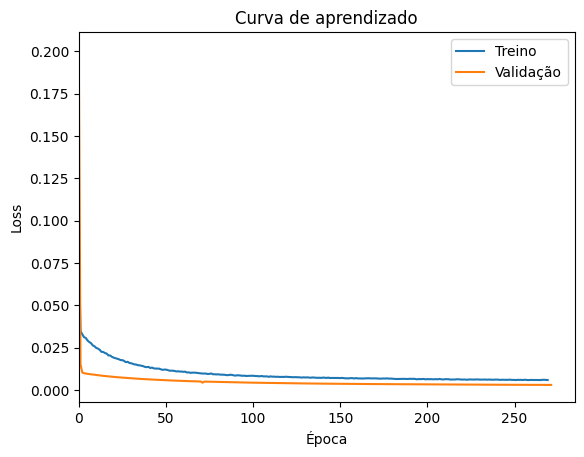

In [39]:
# Plot treino e validação
    
figura, eixo = plt.subplots()

ca_treino_melhor_modelo = melhor_modelo.curva_aprendizado_treino
ca_val_melhor_modelo = melhor_modelo.curva_aprendizado_val

eixo.plot(ca_treino_melhor_modelo, label="Treino")
eixo.plot(ca_val_melhor_modelo, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

A partir do gráfico é possível verificar que, assim como a MLP de teste, ao passar das épocas as curvas de aprendizado de treino e validação tendem a convergir. 

## Testando o melhor modelo encontrado

Novamente, antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.

In [40]:
melhor_modelo.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=117, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2734006184484247, inplace=False)
    (3): Linear(in_features=117, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [41]:
datamodule.setup("test")

with torch.no_grad():
    X_true = datamodule.X_teste

    y_true = datamodule.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = melhor_modelo(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

76.0685088240647


/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Conclusão

Após treino e teste podemos perceber que houve uma melhoria significativa no RMSE do primeiro modelo de teste para o real, que foi otimizado. O RMSE era de $199 kg/hec$ e diminuiu para $76 kg/hec$, uma taxa de dimuição de erro de aproximadamente 62%.

Dessa forma, com base nos gráficos de curva de aprendizado e através de análises de porcentagem, o modelo pode prever rendimentos de plantação com uma taxa de erro baixa. 

Embora a rede tenha sido treinada com dados sintéticos, devido à diferença relativamente grande entre os valores de rendimento, pode-se considerar uma boa rede. Vale ressaltar que a rede poderia ser treinada com dados reais, sendo possível melhorar ainda mais o RMSE da rede.

## Referências

[1] Cassar, Daniel R.; Coletânea de notebooks didáticos  da disciplina de Redes Neurais (NN).
\
[2] LOOMIS, C. Using Optuna to Optimize PyTorch Lightning Hyperparameters. Disponível em: <https://medium.com/optuna/using-optuna-to-optimize-pytorch-lightning-hyperparameters-d9e04a481585>.
\
[3] optuna-examples/pytorch/pytorch_lightning_simple.py at main · optuna/optuna-examples. Disponível em: <https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_lightning_simple.py#L161>.
\
[4] optuna.create_study — Optuna 3.6.1 documentation. Disponível em: <https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html>.
\
[5] optuna.trial.Trial — Optuna 3.6.1 documentation. Disponível em: <https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html>.


### Observação pertinente: 
O [chatGPT](https://chatgpt.com/share/51a44c37-d3be-4d8b-b7d5-6c2d4866ab1c) foi usado para melhorar e corrigir os comentarios e discuções. 